In [1]:
!echo $HOSTNAME

n-62-20-9


In [29]:
import numpy as np
import math
import scipy as sp
from scipy import interpolate
from numpy.linalg import solve
import matplotlib.pyplot as plt
from skimage.measure import profile_line
from time import time
import spekpy
import os
import skimage

In [25]:
from cil.optimisation.algorithms import GD, FISTA, PDHG
from cil.optimisation.operators import BlockOperator, GradientOperator,\
                                       GradientOperator
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation, \
                                       ZeroFunction

from cil.io import NikonDataReader
from cil.utilities.jupyter import islicer
from cil.utilities.display import show_geometry, show2D
from cil.recon import FDK
from cil.plugins.tigre import FBP, ProjectionOperator
from cil.processors import TransmissionAbsorptionConverter, Slicer
from cil.optimisation.algorithms import CGLS, SIRT

from cil.framework import ImageData, ImageGeometry, AcquisitionData, AcquisitionGeometry
from cil.utilities.noise import gaussian, poisson

In [4]:
def fun_attenuation():
    # mu/rho in (cm2/g)
    # multiply by density of gold to get mu in (cm^{-1})
    data = []
    # ORIGINAL DATA IN MEV!!!! SO CONVERT TO KEV
    base_dir = os.path.abspath('/dtu/3d-imaging-center/projects/2022_DANFIX_Vindelev/analysis/s214743_bsc/')
    file_path = os.path.join(base_dir,'NIST_gold_only_dat.txt')
    with open(file_path, 'r') as file:
        for line in file:
            # Split the line into components
            parts = line.split()

            # Check if the line has at least 3 elements and the first is a number
            if len(parts) >= 3 and parts[0].replace('.', '', 1).replace('E-', '', 1).replace('E+', '', 1).isdigit():
                energy = float(parts[-3])  # Energy value
                mu_rho = float(parts[-2])  # mu/rho value
                mu_en_rho = float(parts[-1])  # mu_en/rho value
                data.append((energy, mu_rho, mu_en_rho))

    # Example: Print the first few entries
    data = np.array(data)
    # print(data)
    # plt.loglog(data[:,0],data[:,1])
    # plt.show()
    # plt.loglog(data[:,0],data[:,2])
    # plt.show()


    # Assuming 'data' is a list of tuples (energy, mu_rho, mu_en_rho)
    # convert to KEV
    rho = 19.3 # g/cm^3
    # rho = 1
    energies = 1000*data[:,0]
    mu_rhos = data[:,1]
    mu = mu_rhos * rho

    ###
    # Create a spline interpolator
    # spline = interpolate.InterpolatedUnivariateSpline(energies, mu_rhos, k=1)

    # # Define a function that uses this interpolator
    # def estimate_attenuation(energy):
    #     return spline(energy)
    ###
    ###
    log_energies = np.log10(energies)
    log_mu = np.log10(mu)
    spline = interpolate.InterpolatedUnivariateSpline(log_energies, log_mu, k=1)
    def estimate_attenuation(energy):
        log_energy = np.log10(energy)  # Convert input energy to log domain
        log_attenuation = spline(log_energy)  # Perform interpolation in log domain
        return np.power(10,log_attenuation)  # Convert back to original domain
    
    
    # plt.plot(log_energies,log_mu_rhos)
    # plt.show()
    # plt.figure()
    ###
    # Generate a log-spaced range of energy values for plotting
    energy_plot_range = np.logspace(np.log10(min(energies)), np.log10(max(energies)), 500)

    # Example usage
    # energy = 0.005  # 5 keV
    # attenuation = estimate_attenuation(energy)
    # print(f"Estimated attenuation at {energy} keV is {attenuation}")

    # Plot using log-log scale
    # plt.loglog(energy_plot_range, spline(energy_plot_range), label='Spline Interpolation')  # Spline curve
    plt.loglog(energy_plot_range, estimate_attenuation(energy_plot_range), label='Spline Interpolation (Linear)')
    plt.loglog(energies, mu, 'o', label='Data Points',markersize=4)#,color='black')  # Data points


    plt.xlabel('Energy (keV)')
    plt.ylabel('Attenuation Coefficient')
    plt.title('Attenuation Coefficient vs Energy')
    plt.legend()
    plt.show()

    return estimate_attenuation

def create_circle_image(image_size, radius, center):
    # Initialize a square image with zeros (black)
    image = np.zeros((image_size, image_size))

    # Create the circle
    for x in range(image_size):
        for y in range(image_size):
            # Check if the pixel is inside the circle
            # x is now the vertical coordinate, and y is the horizontal coordinate
            if (x - center[0]) ** 2 + (y - center[1]) ** 2 < (radius+0.5) ** 2:
                image[x, y] = 1  # Set pixel value to 1 (white) inside the circle
    
    return image

def generate_triangle_image(img_size, triangle_size, corner_coords):
    """
    Generate a right triangle test image.

    Parameters:
    img_size (tuple): Size of the image (width, height)
    triangle_size (tuple): Size of the right triangle (base, height)
    corner_coords (tuple): Coordinates of the right-angled corner (x, y)
    """
    # Create a blank image
    image = np.zeros(img_size)

    # Define the triangle
    for x in range(corner_coords[0], min(corner_coords[0] + triangle_size[0], img_size[0])):
        for y in range(corner_coords[1], min(corner_coords[1] + triangle_size[1], img_size[1])):
            if (x - corner_coords[0]) + (y - corner_coords[1]) < triangle_size[0]:
                image[y, x] = 1  # Set pixel value

    return image

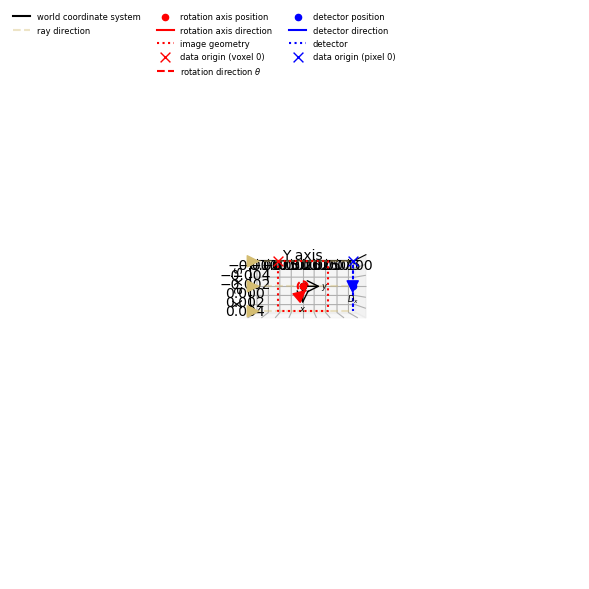

In [5]:
angles = np.linspace(start=0, stop=180, num=1, endpoint=False)
physical_size = 0.01 # cm
voxel_num = 10000
voxel_size = physical_size/voxel_num

ig = ImageGeometry(voxel_num_x=voxel_num, voxel_num_y=voxel_num, voxel_size_x=voxel_size, voxel_size_y=voxel_size, center_x=0, center_y=0)

factor = 1
panel_num_cells = math.ceil(factor*voxel_num)
panel_cell_length = 1/factor * voxel_size
ag = AcquisitionGeometry.create_Parallel2D(ray_direction=[0,1], detector_position=[0,physical_size], detector_direction_x=[1,0], rotation_axis_position=[0,0])\
    .set_panel(num_pixels=panel_num_cells,pixel_size=panel_cell_length)\
    .set_angles(angles=angles)

plot_size = 6
show_geometry(ag, ig, grid=True, figsize=(plot_size, plot_size),fontsize=plot_size)

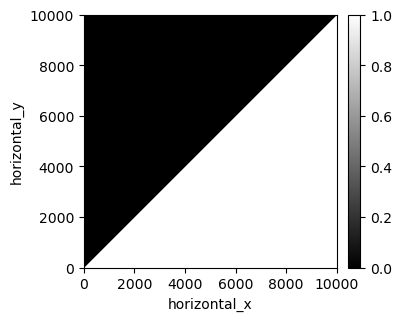

In [6]:
# im_arr = create_circle_image(image_size=voxel_num, radius=voxel_num//3, center=[voxel_num//2, voxel_num//2])
# im_arr = im_arr.astype('float32')

tri_width = voxel_num
corner = 0

img_size = (voxel_num, voxel_num)  # Image size: 100x100 pixels
triangle_size = (tri_width, tri_width)  # Triangle size: base=50, height=50 pixels
corner_coords = (corner, corner)  # Right-angled corner at (25, 25)
triangle_image = generate_triangle_image(img_size, triangle_size, corner_coords)
im_arr = np.rot90(triangle_image, 1)
im_arr = im_arr.astype('float32')
# plt.imshow(im_arr,cmap='gray')
# plt.xticks([])
# plt.yticks([])
# plt.show()

image = ImageData(array=im_arr.T,geometry=ig)
# show2D(image)
show2D(image, size=(6,6))

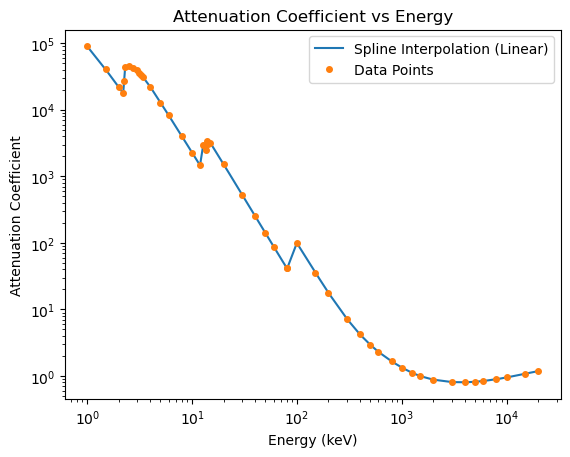

In [7]:
mu = fun_attenuation()

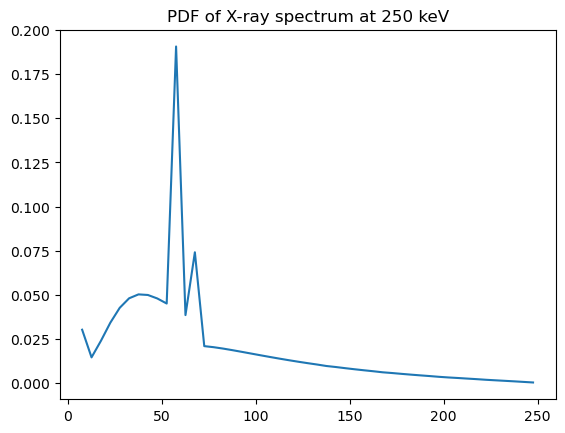

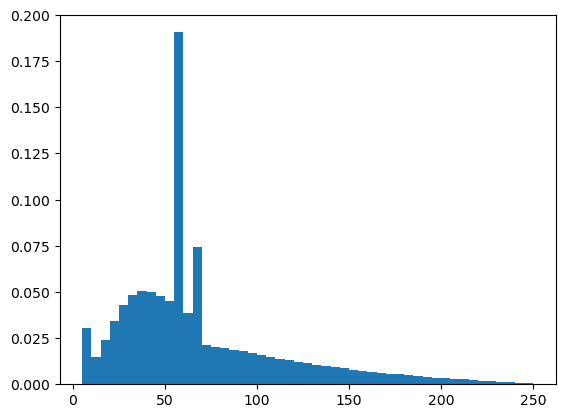

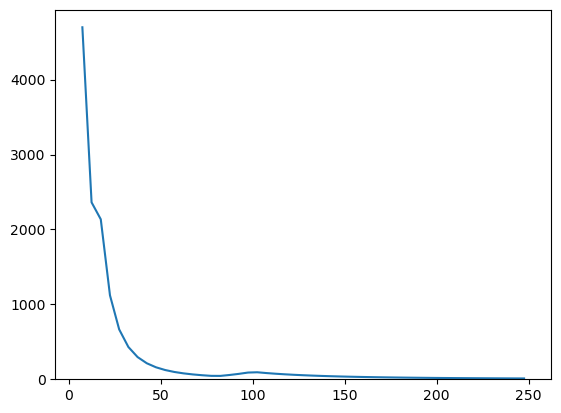

In [8]:
# tube_potential = 120 # keV
tube_potential = 250
anode_angle = 12 # deg
bin_width = 5 # keV
# spectrum = spekpy.Spek(kvp=tube_potential, th=anode_angle, dk=bin_width, mu_data_source='nist', physics='casim')
spectrum = spekpy.Spek(kvp=tube_potential, th=anode_angle, dk=bin_width, mu_data_source='nist', physics='spekcalc')
spectrum = np.array(spectrum.get_spectrum())
spectrum[1,:] /= np.sum(spectrum[1,:])
plt.plot(spectrum[0,:],spectrum[1,:])
plt.title(f'PDF of X-ray spectrum at {tube_potential} keV')
plt.show()
plt.figure()

num_bins = spectrum.shape[1]

bin_centers = spectrum[0,:]
bin_heights = spectrum[1,:]
bin_edges = np.array(bin_centers) - bin_width/2
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
plt.bar(bin_centers, bin_heights, align='center', width=np.diff(bin_edges))
# plt.plot(bin_centers-0.1, bin_heights, 'r.', markersize=5)
# plt.scatter(bin_centers, bin_heights)
plt.show()

plt.bar(bin_centers, bin_heights, align='center', width=np.diff(bin_edges))
plt.plot(bin_centers, mu(bin_centers))

[9.9937404e-07 1.9994675e-06 2.9995610e-06 ... 9.9969339e-03 9.9979341e-03
 9.9989343e-03]
[0.9996031  0.99920684 0.99881184 ... 0.34762946 0.34760422 0.34757882]
1.0
[3.9698611e-04 7.9347374e-04 1.1888654e-03 ... 1.0566182e+00 1.0566908e+00
 1.0567639e+00]


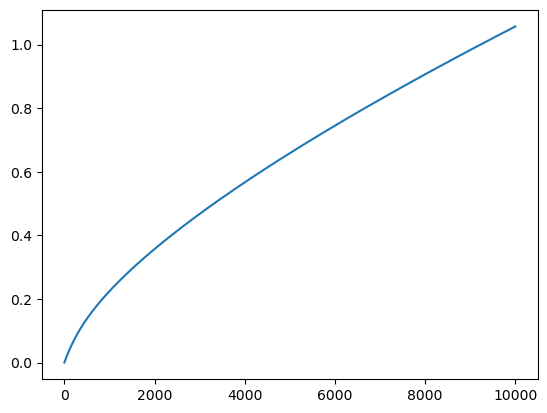

In [9]:
A = ProjectionOperator(ig, ag, 'Siddon', device='gpu')
b = A.direct(image)
# b.reorder(order='tigre')
# print(type(b))
# print(b)
# show2D(b)

d = b.as_array()
I = np.zeros(b.shape, dtype='float32')
I0 = 0
print(d)
for i in range(num_bins):
    E = bin_centers[i]
    I0_E = bin_heights[i]
    I0 += I0_E
    # print(mu(E))
    # print(mu(E)*d)
    # print(I0_E * np.exp(-mu(E)*d))
    I += I0_E * np.exp(-mu(E)*d)
    # I += I0_E
    # print(mu(E))

print(I)
print(I0)
# plt.hist(I.flatten())
data = AcquisitionData(array=-np.log(I/I0), geometry=ag)
b = data.as_array()
print(b)
# asd = I[5,:]
# print(b.as_array())
plt.plot(np.arange(1,b.size+1,1),b)

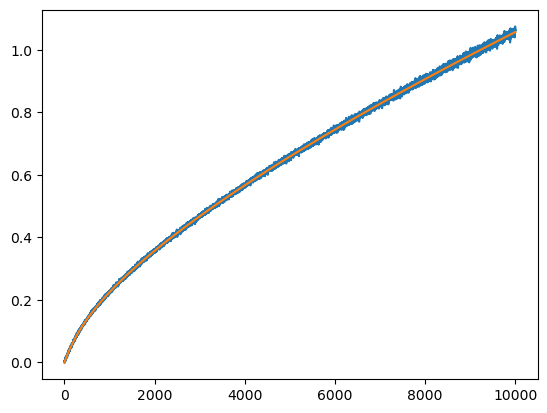

In [47]:
b_noisy = np.clip(a=skimage.util.random_noise(b, mode='gaussian',clip=False, mean=0, var=(1/(400*I))**2), a_min=0, a_max=None)
# plt.plot(gaussian(b))
plt.plot(b_noisy)
plt.plot(b)

In [10]:
# E_eff = np.sum(bin_centers*bin_heights)
# print(np.sum(bin_heights))
# print(f'E_eff: {E_eff}')
# b_mono = -np.log(np.exp(-mu(E_eff)*d))

mu_eff = np.sum(bin_heights * mu(bin_centers))
# b_mono = -np.log(np.exp(-mu_eff*d))
b_mono = d*mu_eff
b_mono

array([3.9728615e-04, 7.9485826e-04, 1.1924304e-03, ..., 3.9741309e+00,
       3.9745286e+00, 3.9749260e+00], dtype=float32)

In [11]:
print(ig)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x10000,y10000
voxel_size : x1e-06,y1e-06
center : x0,y0



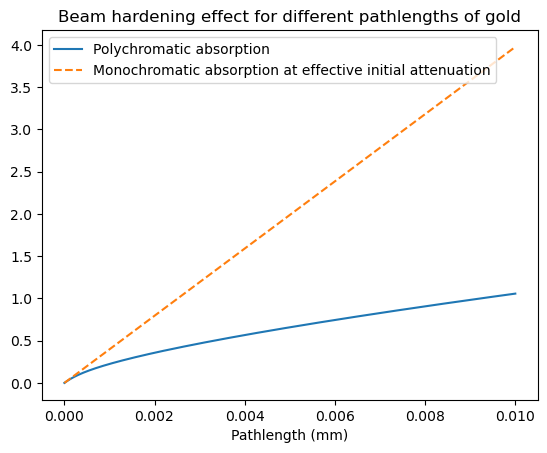

In [50]:
plt.plot(voxel_size * np.arange(1,b.size+1,1),b,label='Polychromatic absorption')
plt.plot(voxel_size * np.arange(1,b_mono.size+1,1),b_mono,'--',label='Monochromatic absorption at effective initial attenuation')
plt.xlabel('Pathlength (mm)')
plt.title('Beam hardening effect for different pathlengths of gold')
plt.legend()
plt.show()

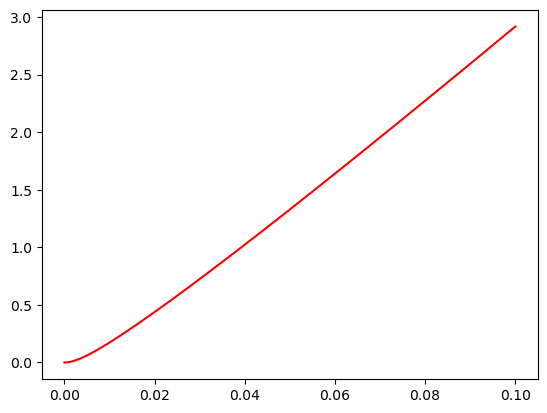

In [18]:
plt.plot(10*voxel_size * np.arange(1,b.size+1,1),b_mono-b,'r')

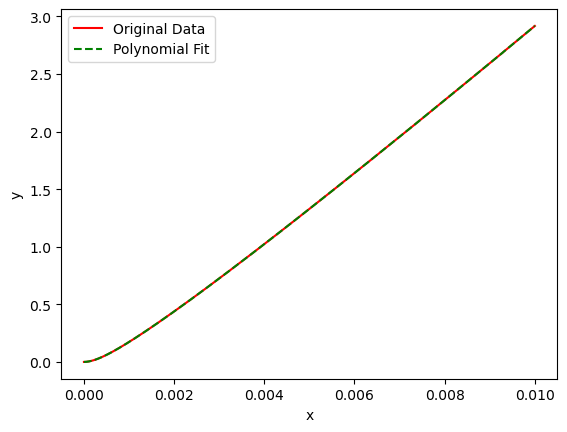

In [19]:
x = voxel_size * np.arange(1,b.size+1,1)
y = b_mono-b
y_spline = interpolate.InterpolatedUnivariateSpline(x, y, k=1)
# x_fit = np.linspace(min(x), max(x), 400)
y_fit = y_spline(x)

base_dir = os.path.abspath('/dtu/3d-imaging-center/projects/2022_DANFIX_Vindelev/analysis/s214743_bsc/')
file_path = os.path.join(base_dir,'bh_absorption_corrections.txt')
X = np.column_stack((x,y))
np.savetxt(file_path,X)

plt.plot(x, y,'r', label='Original Data')
plt.plot(x, y_fit, 'g--', label='Polynomial Fit')
# plt.loglog(x, y,'r', label='Original Data')
# plt.loglog(x, y_fit, 'g--', label='Polynomial Fit')
# plt.semilogy(x, y,'r', label='Original Data')
# plt.semilogy(x, y_fit, 'g--', label='Polynomial Fit')
plt.legend()
# plt.xlim(0,0.01)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [15]:
# x = 10*physical_size/voxel_num * np.arange(1,b.size+1,1)
# y = b_mono-b
# coefficients = np.polyfit(x, y, 3)
# print("Coefficients of the polynomial:", coefficients)
# p = np.poly1d(coefficients)

# x_fit = np.linspace(min(x), max(x), 400)
# # Calculate the y values based on the polynomial function
# y_fit = p(x_fit)

# # Plotting
# plt.plot(x, y,'r', label='Original Data')
# plt.plot(x_fit, y_fit, 'g--', label='Polynomial Fit')
# plt.legend()
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Third Degree Polynomial Fit')
# plt.show()

In [16]:
# plt.plot(b,10*physical_size/voxel_num * np.arange(1,b.size+1,1),label='Polychromatic absorption for test image')
# plt.plot(b_mono,10*physical_size/voxel_num * np.arange(1,b_mono.size+1,1),'--',label='Monochromatic absorption at effective energy')